In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pandas as pd
import psycopg2
from psycopg2.extras import RealDictCursor

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
def query_db(query):
 '''
    Runs sql query on 311 database and returns a pandas DataFrame.
    Redshift is a data warehouse based on PostgreSQL, so syntax is mostly the same
    '''
 host = 'interview-ds.ckgnwnm6pw4o.us-east-1.redshift.amazonaws.com'
 port = 5439
 db = 'interview'
 username = 'dsguest'
 password = 'nX9EFYUZ5Yu#0q'
 conn = psycopg2.connect(host=host, port=port, dbname=db, user=username, password=password)
 cur = conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
 cur.execute(query)
 rows = cur.fetchall()
 
 rows = pd.DataFrame(rows)
 return rows
# Example usage:
#rows= (query_db("SELECT unique_key, created_date, agency, complaint_type,incident_zip, city ,borough, vehicle_type FROM public.three_one_one WHERE created_date >= '2020-01-01';"))


In [3]:
"""Querying only the data after 2019"""

data_since_2019= (query_db("SELECT * FROM public.three_one_one WHERE created_date >= '2019-1-1';"))
data =data_since_2019.copy()
data['Resolving_time'] = data_since_2019['closed_date'].dt.date - data_since_2019['created_date'].dt.date

In [37]:

#data Cleaning
data[['latitude', 'longitude','x_coordinate_state_plane', 'y_coordinate_state_plane']] = data[['latitude', 'longitude','x_coordinate_state_plane', 'y_coordinate_state_plane']].astype(np.float64)
data['created_time']= pd.to_datetime(data['created_date']).dt.time

# ***How many incidents were opened in each year (beginning with 2010)? ***



In [4]:
"""NUMBER OF INCIDENTS BY YEAR """

incidents = (query_db("SELECT EXTRACT(year FROM created_date) AS year, COUNT(unique_key) AS num_incidents FROM public.three_one_one where created_date >= '2010-1-1' GROUP BY year ORDER BY year ASC;"))

In [5]:
incidents

,year,num_incidents
0,2010,2031813
1,2011,1961598
2,2012,1796207
3,2013,1839974
4,2014,2114000
5,2015,2300760
6,2016,2391426
7,2017,2491969
8,2018,2747985
9,2019,1675384


# ***Which borough has the most incidents? ***


In [6]:
"""Borroughs with number of incidents in each"""

boroughs= (query_db("SELECT borough, SUM(unique_key) FROM public.three_one_one GROUP BY borough;"))

In [7]:
"""Borough with the most incidents"""
pd.DataFrame(boroughs.iloc[boroughs['sum'].idxmax()])

,2
borough,BROOKLYN
sum,197952465359308


In [10]:
"""Highest complaint type per borrough"""
complaints_per_type_per_borough= data[[ 'borough', 'complaint_type']].groupby(['borough'])['complaint_type'].value_counts().reset_index(name='counts')

indx = complaints_per_type_per_borough.groupby('borough')['counts'].transform(max)==complaints_per_type_per_borough['counts']
complaints_per_type_per_borough[indx]


,borough,complaint_type,counts
0,BRONX,HEAT/HOT WATER,42696
192,BROOKLYN,Illegal Parking,42134
401,MANHATTAN,Noise - Residential,30435
606,QUEENS,Illegal Parking,38783
813,STATEN ISLAND,Request Large Bulky Item Collection,8744
994,Unspecified,Benefit Card Replacement,4555


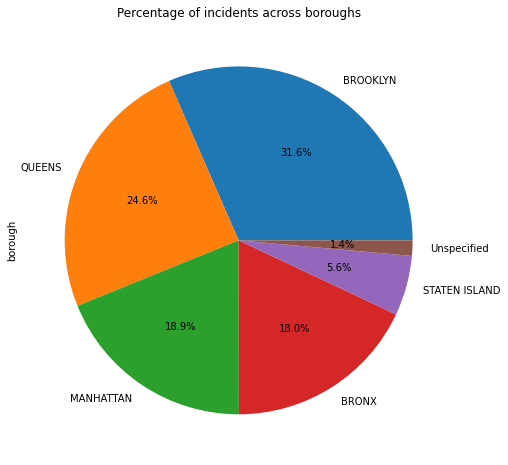

In [12]:
"""Percentage of incidents across boroughs"""
data["borough"].value_counts().plot(kind='pie',autopct="%.1f%%",figsize=(8,8))
plt.title("Percentage of incidents across boroughs")
plt.show()

In [13]:
"""Checking to see whether any column has null values"""
check_na_dict ={}
check_na= []
print("LIST OF COLUMNS WITH NULL VALUES \n")
for i in data_since_2019.columns:
  val = data_since_2019[i].isna().any()
  check_na.append(val)
  check_na_dict[i] = val 
  if val == True:
    print("- ",i)

LIST OF COLUMNS WITH NULL VALUES 

-  closed_date
-  incident_zip
-  due_date
-  resolution_action_updated_date
-  bbl
-  x_coordinate_state_plane
-  y_coordinate_state_plane
-  latitude
-  longitude


**Data Exploration**

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1675384 entries, 0 to 1675383
Data columns (total 42 columns):
 #   Column                          Non-Null Count    Dtype          
---  ------                          --------------    -----          
 0   unique_key                      1675384 non-null  int64          
 1   created_date                    1675384 non-null  datetime64[ns] 
 2   closed_date                     1569188 non-null  datetime64[ns] 
 3   agency                          1675384 non-null  object         
 4   agency_name                     1675384 non-null  object         
 5   complaint_type                  1675384 non-null  object         
 6   descriptor                      1675384 non-null  object         
 7   location_type                   1675384 non-null  object         
 8   incident_zip                    1617058 non-null  float64        
 9   incident_address                1675384 non-null  object         
 10  street_name                   

In [15]:
data.describe(include='object')

,agency,agency_name,complaint_type,descriptor,location_type,incident_address,street_name,cross_street_1,cross_street_2,intersection_street_1,...,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location
count,1675384,1675384,1675384,1675384,1675384,1675384,1675384,1675384,1675384,1675384,...,1675384,1675384,1675384,1675384,1675384,1675384,1675384,1587132,1587132,1675384
unique,27,412,362,1181,157,429306,13481,16315,16582,11524,...,4,12,9481,65,51,4,1832,445865,445865,445870
top,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,,,,,,,...,,,,,,,,40.721959131992640,-73.80969682426189,
freq,524723,524194,145279,168427,378151,211631,211725,631209,634739,1222689,...,1675179,1674064,1657105,1673107,1672709,1672710,1671780,4116,4116,88252


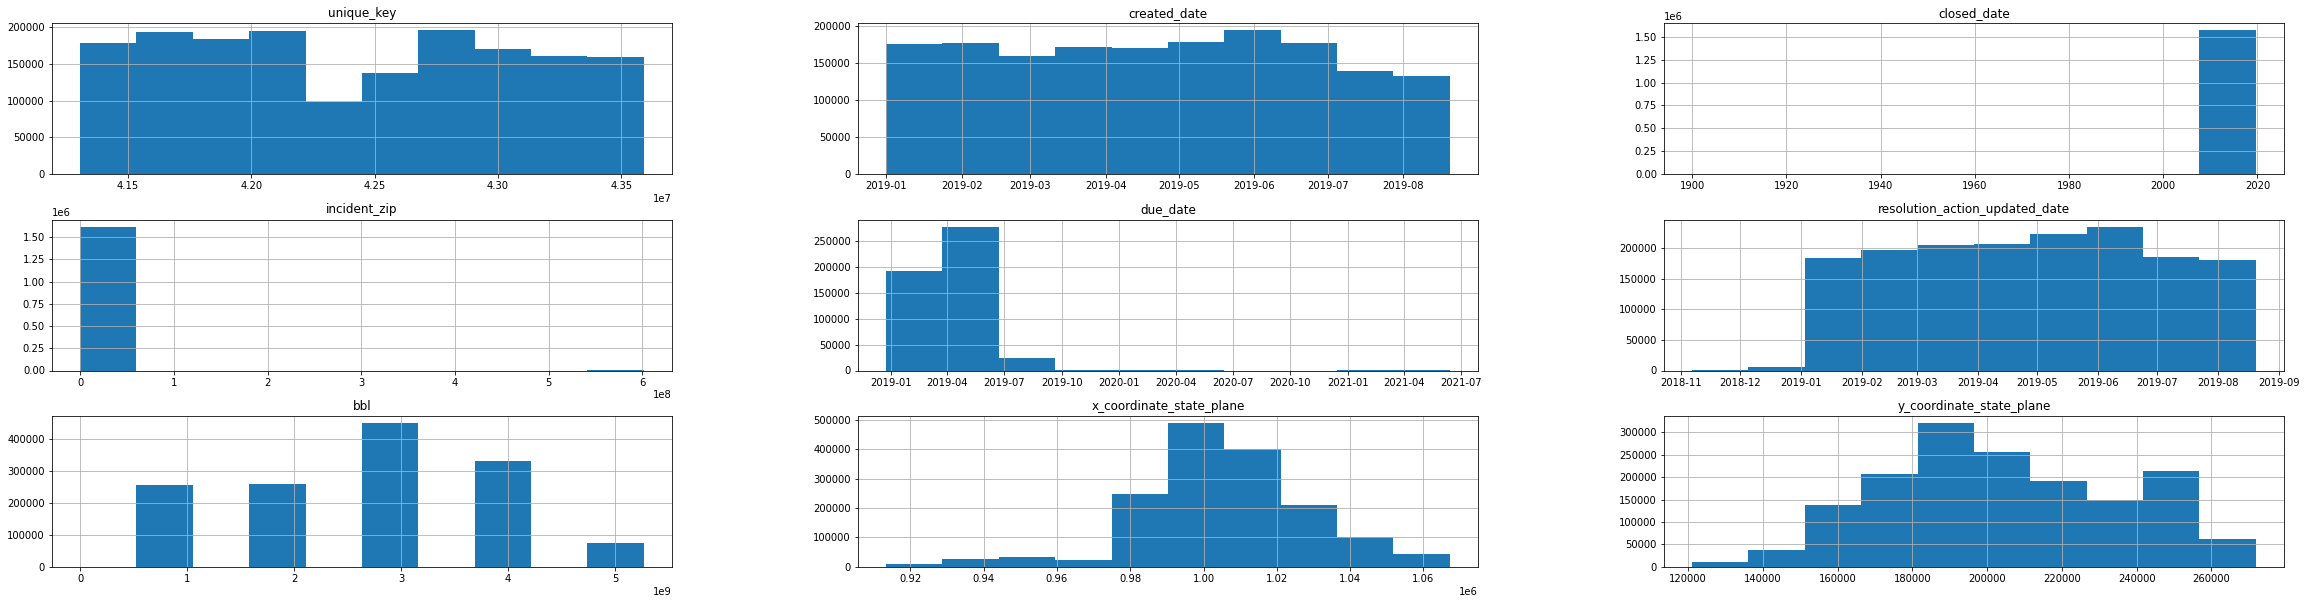

In [16]:

data.hist(figsize=(40,10))
plt.show()

In [17]:
"""Checking to see whether any column has null values"""
check_na_dict ={}
check_na= []
print("LIST OF COLUMNS WITH NULL VALUES")
for i in data_since_2019.columns:
  val = data_since_2019[i].isna().any()
  check_na.append(val)
  check_na_dict[i] = val 
  if val == True:
    print(i,':' ,val)

LIST OF COLUMNS WITH NULL VALUES
closed_date : True
incident_zip : True
due_date : True
resolution_action_updated_date : True
bbl : True
x_coordinate_state_plane : True
y_coordinate_state_plane : True
latitude : True
longitude : True


# **Analysis of Complaint Types** 


* *NYPD receives the most service_requests.*
* *The most common complaint type for NYPD is Noise-Residential.*
* *Noise-Residential is the most common complaint_type across all agencies.*
* *Top complaint in Manhattan is Noise-Residential*
* *Brooklyn has the top most Noise-Residential Complaints*






**Complaint types across all boroughs**

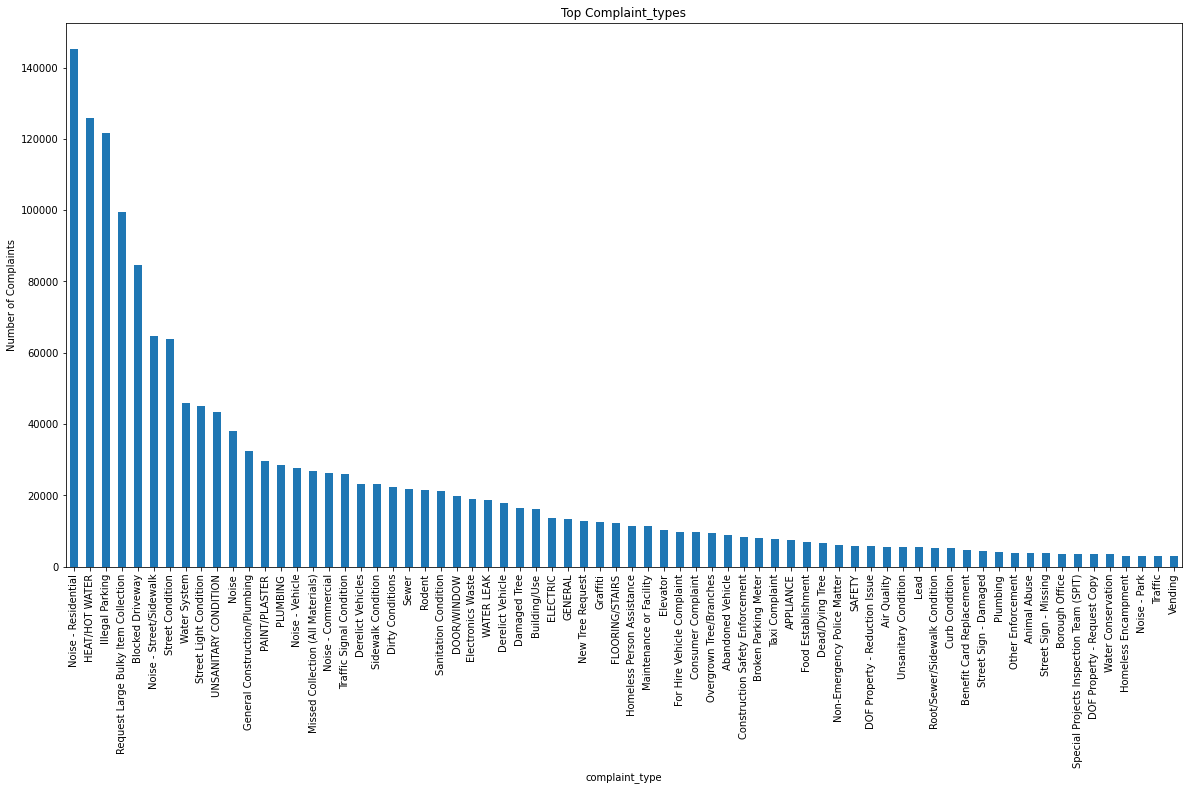

In [60]:


# datam.groupby(['borough','complaint_type']).size()
d=data.complaint_type.value_counts()
max_num = 70
data['complaint_type'].value_counts().nlargest(max_num).plot(kind= "bar" ,figsize =(20,10))
plt.title("Top Complaint_types")
plt.xlabel("complaint_type")
plt.ylabel("Number of Complaints")
plt.show()

**Visualizing Geo-locations of Noise-Residential complaints across Boroughs**

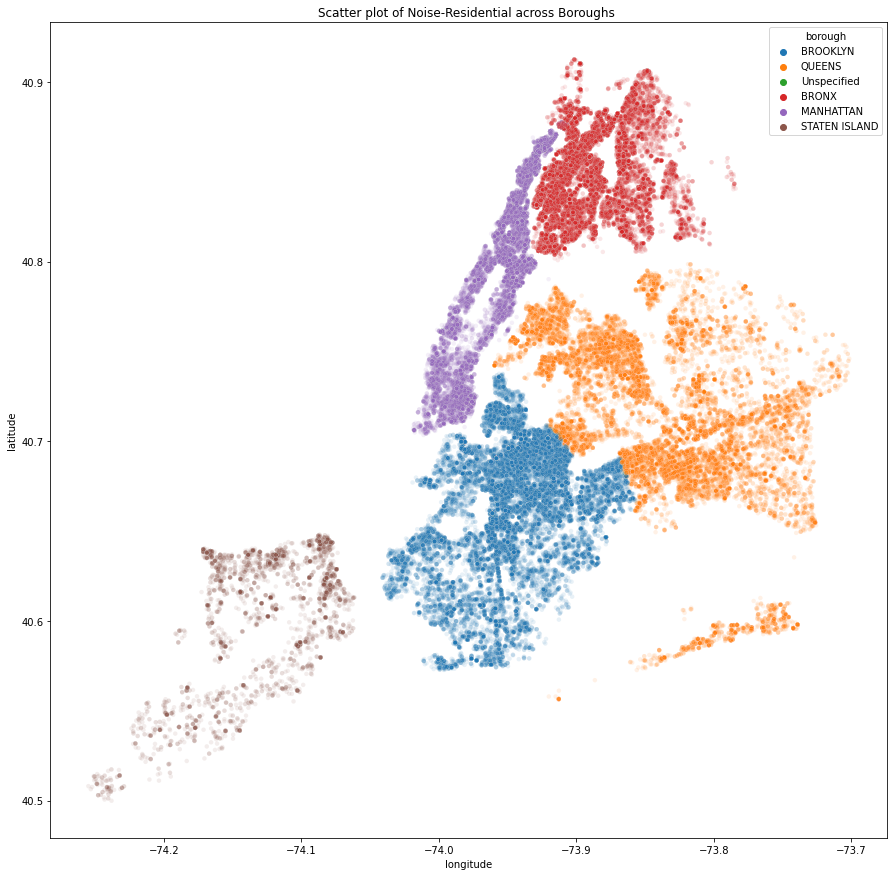

In [40]:



# bx=data["complaint_type"]== 'Rodent']data[.plot(kind="scatter", x= "latitude", y = 'longitude', hue= 'borough', figsize=(10,8), alpha= 0.1)
plt.figure(figsize=(15,15))
noise_res= data[data["complaint_type"]== 'Noise - Residential']
ax=sns.scatterplot(x= noise_res['longitude'],y=noise_res['latitude'], hue='borough',s=20, data= noise_res, alpha= 0.1)

plt.title("Scatter plot of Noise-Residential across Boroughs ")
plt.show()

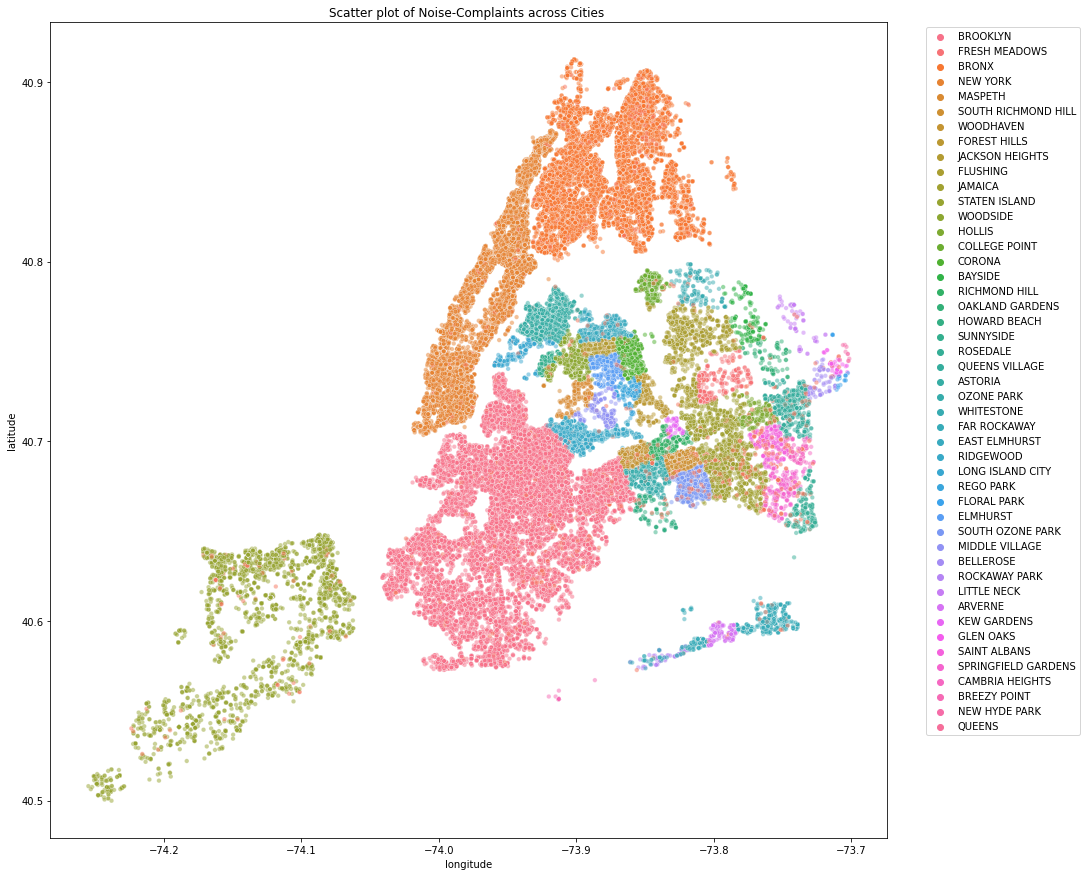

In [39]:
plt.figure(figsize=(15,15))
noise_res= data[data["complaint_type"]== 'Noise - Residential']
ax=sns.scatterplot(x= noise_res['longitude'],y=noise_res['latitude'], hue='city',s=20, data= noise_res, alpha= 0.5)

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.title("Scatter plot of Noise-Complaints across Cities ")
plt.show()

**Percentage of complaint_type: 'Noise-Residential' across the boroughs**

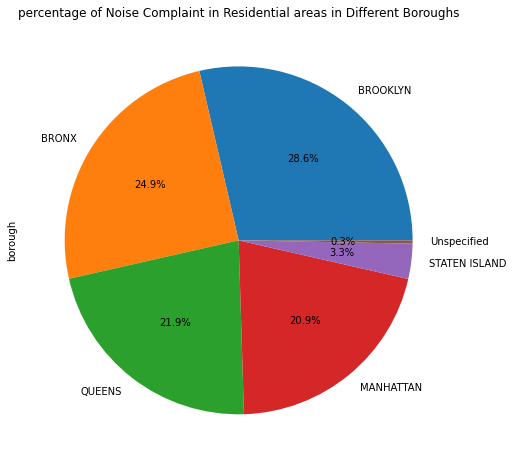

In [21]:
data['borough'][data['complaint_type'] == 'Noise - Residential'].value_counts().plot(kind= "pie" ,autopct="%.1f%%",figsize=(8,8))
plt.title("percentage of Noise Complaint in Residential areas in Different Boroughs")
plt.show()

**Scatter plot of noise-complaints in Brooklyn**

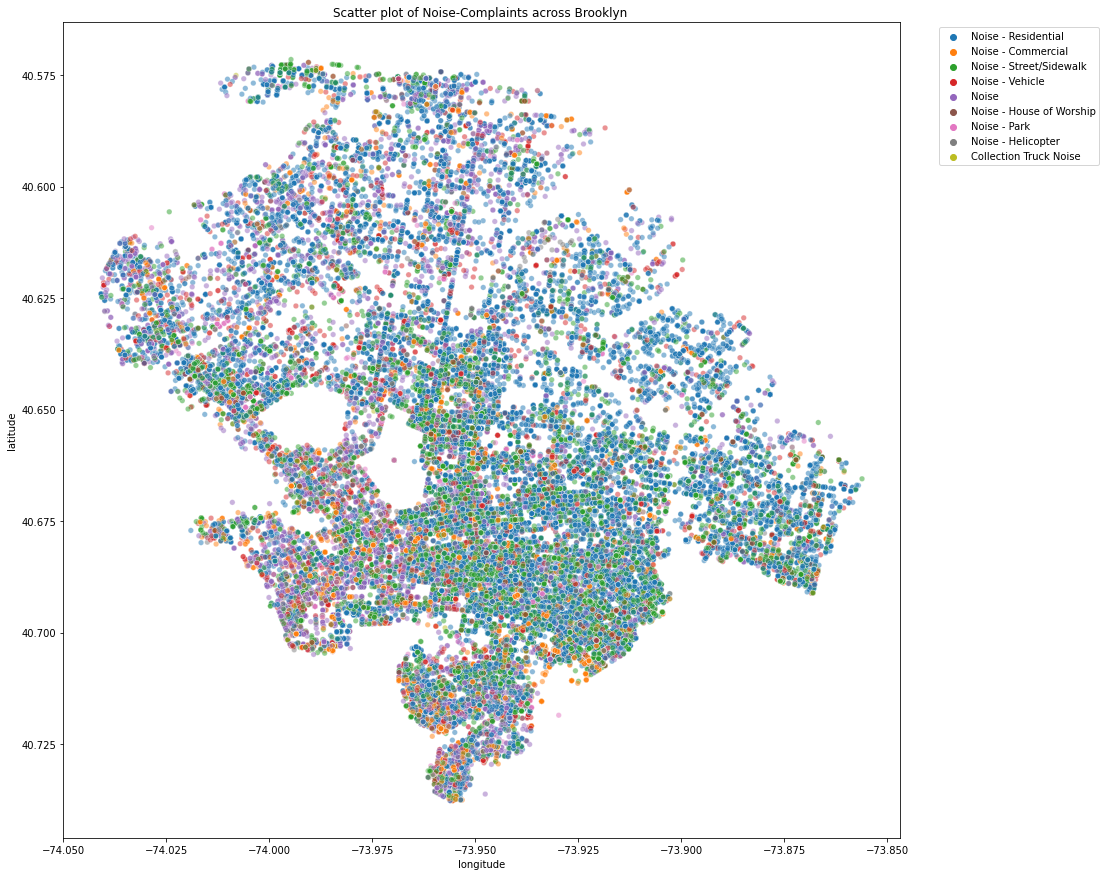

In [76]:

brooklyn = data.loc[(data['borough'] == 'BROOKLYN') & (data['complaint_type'].str.contains('Noise')), ['complaint_type','latitude','longitude', 'Resolving_time','incident_zip']]
brooklyn_noise_res = data.loc[(data['borough'] == 'BROOKLYN') & (data['complaint_type'] == 'Noise - Residential'), ['complaint_type','latitude','longitude', 'Resolving_time','incident_zip']]
plt.figure(figsize=(15,15))
bx=sns.scatterplot(x= brooklyn['longitude'],y= brooklyn['latitude'], hue= 'complaint_type',s= 30,data= brooklyn, alpha= 0.5)
cx=sns.scatterplot(x= brooklyn_noise_res['longitude'],y= brooklyn_noise_res['latitude'],s= 0,data= brooklyn_noise_res, alpha= 1 , markers= True)

bx.invert_yaxis()
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.title("Scatter plot of Noise-Complaints across Brooklyn ")
plt.show()

*Concentration of noise-residential complaints across brooklyn*

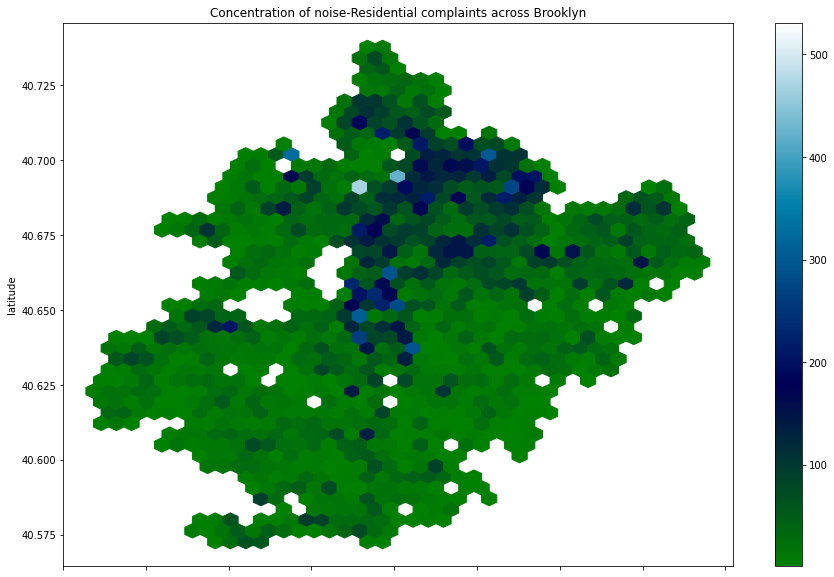

In [77]:
brooklyn_noise_res.plot(kind='hexbin', x='longitude', y='latitude', gridsize=40,
    colormap = 'ocean',mincnt=1, figsize=(15,10))
plt.title("Concentration of noise-Residential complaints across Brooklyn")
plt.show()

**Scatter plot of noise-complaints in Manhattan**

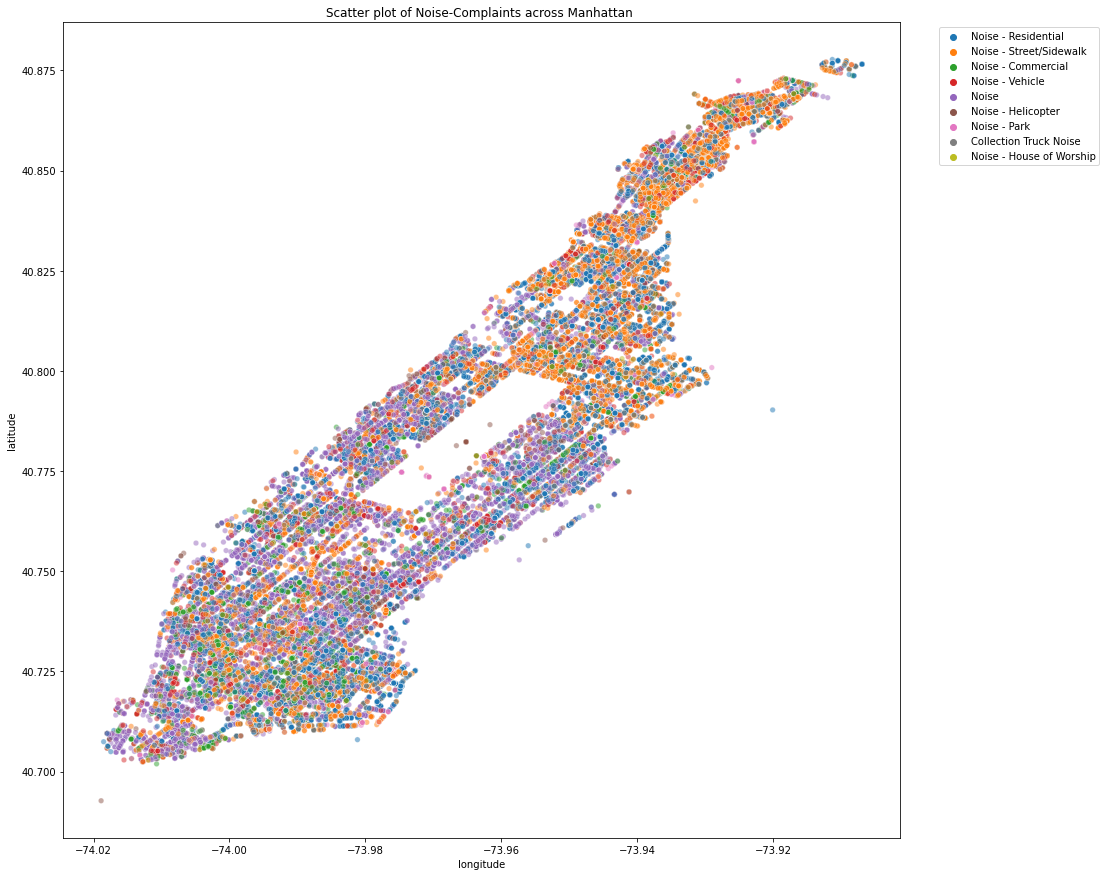

In [41]:


Manhattan = data.loc[(data['borough'] == 'MANHATTAN') & (data['complaint_type'].str.contains('Noise')), ['complaint_type','latitude','longitude', 'Resolving_time','incident_zip']]
Manhattan_noise_res = data.loc[(data['borough'] == 'MANHATTAN') & (data['complaint_type'] == 'Noise - Residential'), ['complaint_type','latitude','longitude', 'Resolving_time','incident_zip']]
plt.figure(figsize=(15,15))
bx=sns.scatterplot(x= Manhattan['longitude'],y= Manhattan['latitude'],hue='complaint_type',s= 30,data= Manhattan, alpha= 0.5)
# cx=sns.scatterplot(x= Manhattan_noise_res['longitude'],y= Manhattan_noise_res['latitude'],s= 0,data= Manhattan_noise_res, alpha= 1 , markers= True)

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.title("Scatter plot of Noise-Complaints across Manhattan ")
plt.show()


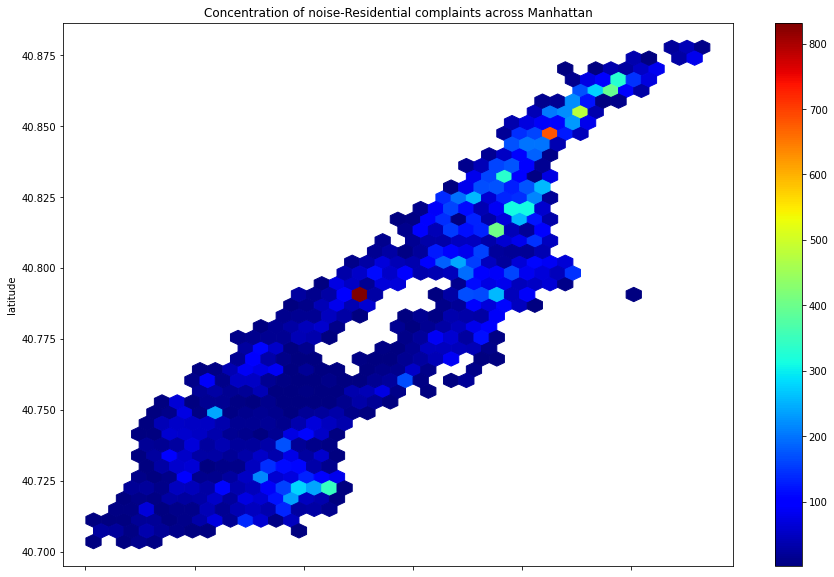

In [78]:
Manhattan_noise_res.plot(kind='hexbin', x='longitude', y='latitude', gridsize=40,
    colormap = 'jet',mincnt=1, figsize=(15,10))
plt.title("Concentration of noise-Residential complaints across Manhattan")
plt.show()

# **ANALYTICS: AGENCIES**

**Agency vs Number of Complaints**

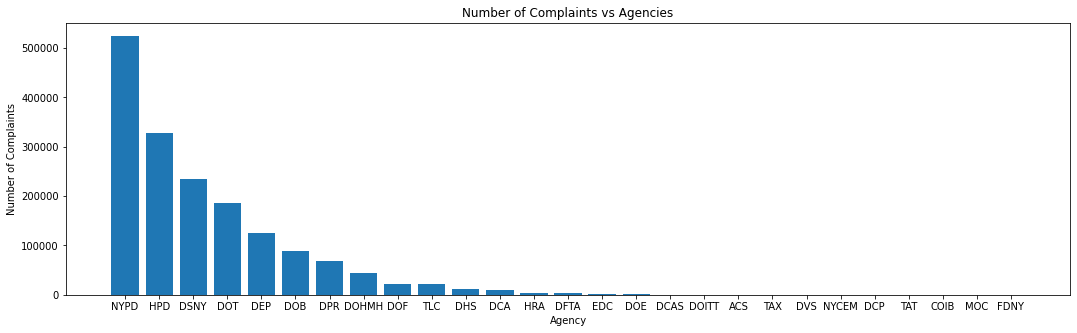

In [56]:

agency, total_no_per_agency= (data['agency'].value_counts(sort=True).keys().tolist()), (data['agency'].value_counts(sort=True).tolist())
plt.figure(figsize=(18, 5))
plt.bar(agency, total_no_per_agency)
plt.xlabel("Agency")
plt.ylabel("Number of Complaints")
plt.title("Number of Complaints vs Agencies")
plt.show()

**Type of Complains vs Number of Complaints among NYPD Service Requests**

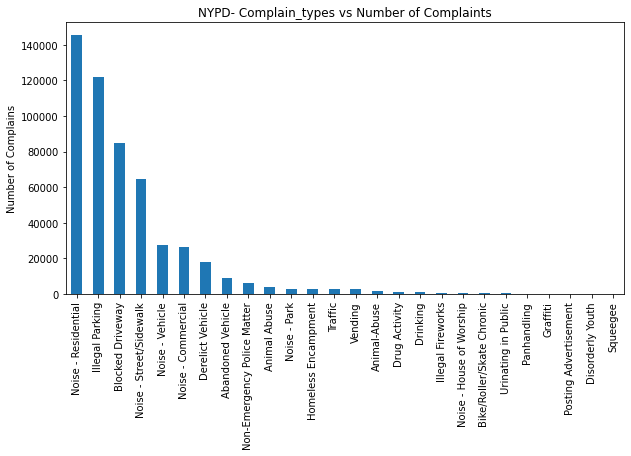

In [57]:
data[data.agency=="NYPD"]['complaint_type'].value_counts().plot(kind="bar", figsize=(10,5))
plt.ylabel("Number of Complains")
plt.title("NYPD- Complain_types vs Number of Complaints")
plt.show()

**Top Complaint Type across all Agencies**

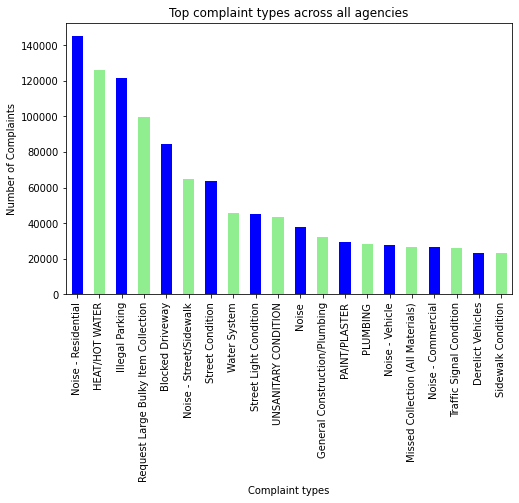

In [58]:
"""Top complaint types across all agencies"""

data['complaint_type'].value_counts().nlargest(20).plot(kind ='bar' , figsize =(8,5) ,color=[ 'blue', 'lightgreen'])
plt.title("Top complaint types across all agencies")
plt.xlabel("Complaint types")
plt.ylabel("Number of Complaints")
plt.show()

**Average resolution times across agencies**

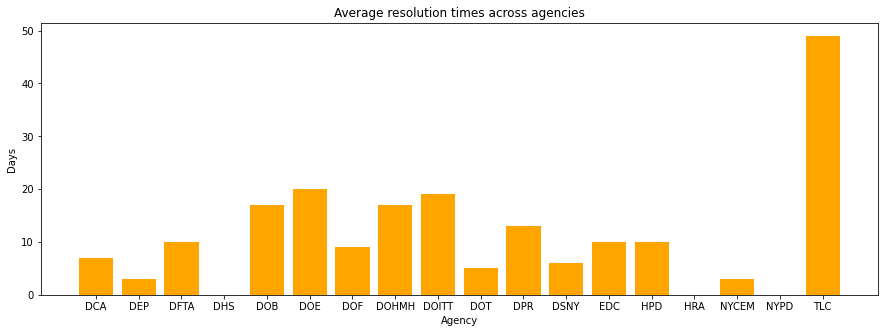

In [59]:

# new=data.fillna(data.mean())
av_resolution_time= data[['agency', 'Resolving_time']].dropna().groupby('agency').mean()
plt.figure(figsize=(15, 5))
plt.bar(av_resolution_time.index,av_resolution_time['Resolving_time'].dt.days, color ='orange')
plt.title("Average resolution times across agencies")
plt.ylabel("Days")
plt.xlabel("Agency")
plt.show()